In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import svm

In [2]:
import tcr_emb_code
import data_processing

!mkdir data/10x_donor1

!mkdir data/10x_donor2

!mkdir data/10x_donor3

!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz -P data/10x_donor1/

!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.tar.gz -P data/10x_donor2/

!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz -P data/10x_donor3/

In [3]:
donor = 'donor1'

In [4]:
barcodes_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/barcodes.tsv'
features_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/features.tsv'
matrix_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/matrix.mtx'
annot_path = 'data/10x_' + donor + '/vdj_v1_hs_aggregated_' + donor + '_all_contig_annotations.csv'

## Data prep

In [5]:
barcodes = data_processing.read_barcodes(barcodes_path)
features = data_processing.read_features(features_path)
matrix_raw = data_processing.read_matrix(matrix_path)

matrix = data_processing.merge_matrix(matrix_raw,barcodes,features)
matrix = data_processing.get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']

matrix_t = data_processing.get_tetramer_matrix(matrix)
matrix_t


,barcode,value,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,AAKGRGAAL,76112470
1,TTTGTCATCAGGTAAA-40,QYDPVAALF,AAKGRGAAL,2
2,TTTGTCATCAGGTAAA-40,KLGGALQAK,AAKGRGAAL,1
3,TTTGTCATCAGGTAAA-40,NLVPMVATV,AAKGRGAAL,1
4,TTTGTCATCAGGTAAA-40,QPRAPIRPI,AAKGRGAAL,1
...,...,...,...,...
204971,GGACATTCACTGTCGG-14,STEGGGLAY,ELRRKMMYM,1
204972,GCTGCGATCTTGTTTG-40,AVFDRKSDAK,AVFDRKSDAK,6
204973,GCTGCGATCTTGTTTG-40,RMFPNAPYL,AVFDRKSDAK,1
204974,GCTGCGATCTTGTTTG-40,FLRGRAYGL,AVFDRKSDAK,1


In [6]:
barcode_tetramer = data_processing.get_barcode_tetramer(matrix)
barcode_tetramer

/home/yuliajk/projects/tcr_emb/data_processing.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tetramers['tetramer'] = tetramers['value']


,barcode,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,76112470
38209278,AACCGCGCATCCGGGT-36,IVTDFSVIK,1377
38240451,CGTTGGGGTAAGTAGT-36,AVFDRKSDAK,1353
38240788,GTGAAGGCAACCGCCA-36,AVFDRKSDAK,1341
38240930,TCGTAGAAGTCCGGTC-36,AVFDRKSDAK,1277
...,...,...,...
17062251,CCTTTCTGTTGCCTCT-34,KLGGALQAK,1
61364026,TGACAACGTTCGGCAC-8,KVAELVHFL,1
17062217,CCGGGATCACGGTTTA-34,KLGGALQAK,1
61363854,TGTGTTTTCCCAACGG-6,KVAELVHFL,1


In [7]:
data = pd.read_csv(annot_path,sep=',')
data_c_annot = data.copy()
data_c_annot = data_c_annot[data_c_annot['is_cell']==True].reset_index(drop=True)
data_c_annot = data_c_annot[data_c_annot['high_confidence']==True]
data_c_annot = tcr_emb_code.filter_table(data_c_annot,'TRB')
data_c = data_c_annot.copy()
data_c = data_processing.merge_anot_matrix(data_c,barcode_tetramer)
data_c = data_c.drop_duplicates(['barcode','tetramer'])
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK,2
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK,5
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV,1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL,1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,GILGFVFTL,67
45172,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK,2
45173,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK,14
45174,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2,KLGGALQAK,28


# Embedding and post proc

In [8]:
data_c = data_c[data_c['tetramer']!='KLGGALQAK'].reset_index(drop=True)

## Embedding

In [9]:
data_c_mir = tcr_emb_code.columns_prep(data_c)

In [20]:
prototypes_path = 'data/prototypes_olga.txt'
chain = 'TRB'
file_path_prefix = '10x_' + chain +'_' + donor + '_'
file_date = '030823'

In [22]:
tcr_emb_code.mir_clac(data_c_mir, file_path_prefix, file_date, chain, prototypes_path,False)

## Post proc of embedded data

In [23]:
prototypes = pd.read_csv(prototypes_path, sep='\t')

In [24]:
data_dists_raw_path = 'data_scripts/' + file_path_prefix + file_date + '.dist.txt'
data_dists_raw = pd.read_csv(data_dists_raw_path, sep = '\t')

In [25]:
data_c_b_dist = tcr_emb_code.mir_dists_format(data_dists_raw, data_c,'barcode')
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_1000,cdr3_1001,cdr3_1002,cdr3_1003,cdr3_1004,cdr3_1005,cdr3_1006,...,j_990,j_991,j_992,j_993,j_994,j_995,j_996,j_997,j_998,j_999
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAAAGG-4,16.0,17.0,19.0,15.0,5.0,27.0,9.0,30.0,41.0,15.0,...,85.0,49.0,62.0,62.0,85.0,62.0,62.0,54.0,54.0,85.0
AAACCTGAGACTGTAA-34,12.0,18.0,19.0,14.0,5.0,2.0,16.0,19.0,12.0,15.0,...,85.0,49.0,62.0,62.0,85.0,62.0,62.0,54.0,54.0,85.0
AAACCTGAGAGCCCAA-5,24.0,29.0,26.0,18.0,14.0,5.0,24.0,36.0,28.0,37.0,...,62.0,45.0,84.0,60.0,62.0,60.0,84.0,65.0,65.0,62.0
AAACCTGAGAGCTGCA-24,23.0,26.0,36.0,37.0,28.0,11.0,19.0,49.0,36.0,31.0,...,62.0,42.0,60.0,81.0,62.0,81.0,60.0,54.0,54.0,62.0
AAACCTGAGAGGGATA-8,26.0,16.0,21.0,24.0,17.0,31.0,13.0,30.0,41.0,23.0,...,85.0,49.0,62.0,62.0,85.0,62.0,62.0,54.0,54.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGAGCCCA-39,11.0,8.0,22.0,19.0,0.0,4.0,8.0,29.0,20.0,24.0,...,41.0,38.0,41.0,43.0,41.0,43.0,41.0,35.0,35.0,41.0
TTTGTCATCGAGGTAG-13,12.0,17.0,20.0,17.0,13.0,-2.0,29.0,22.0,17.0,22.0,...,44.0,38.0,49.0,42.0,44.0,42.0,49.0,44.0,44.0,44.0
TTTGTCATCTCCAACC-24,32.0,17.0,23.0,24.0,19.0,19.0,17.0,39.0,35.0,23.0,...,85.0,49.0,62.0,62.0,85.0,62.0,62.0,54.0,54.0,85.0


# Analysis

## PCA

In [26]:
pca_df, pca_model = data_processing.pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '1 component')

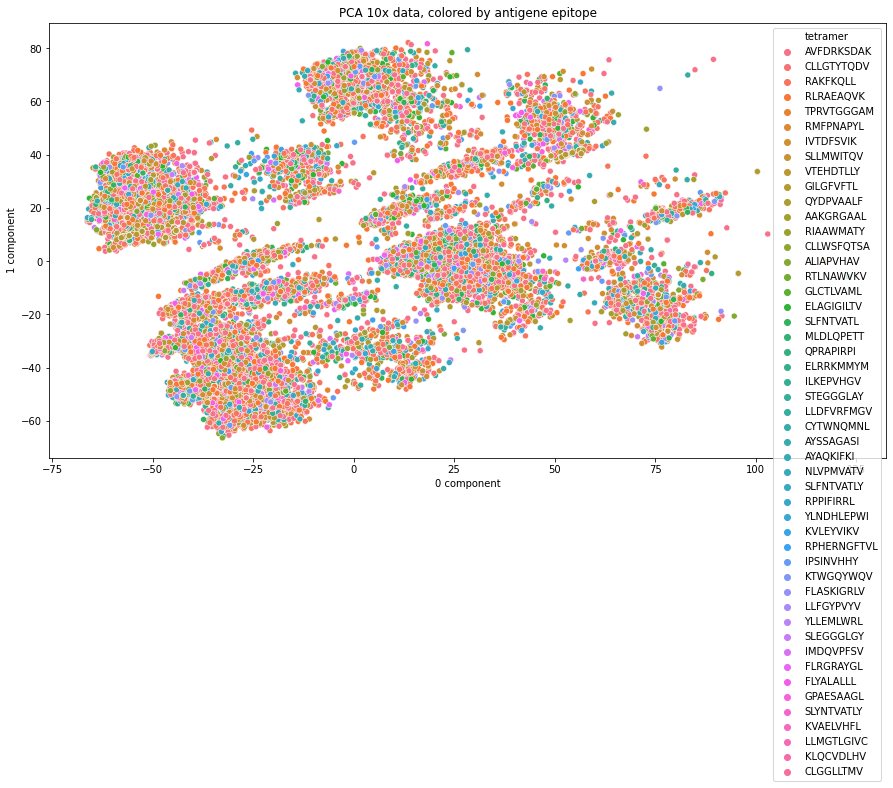

In [27]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

## TSNE

In [28]:
X_embedded = data_processing.tsne(pca_df,2,0,50)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer','cdr3']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of PCA 10x data, colored by antigene epitope')

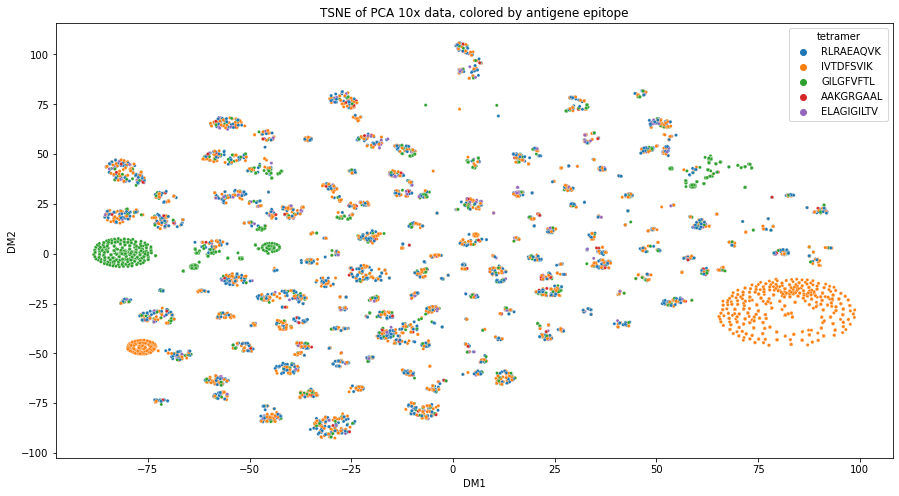

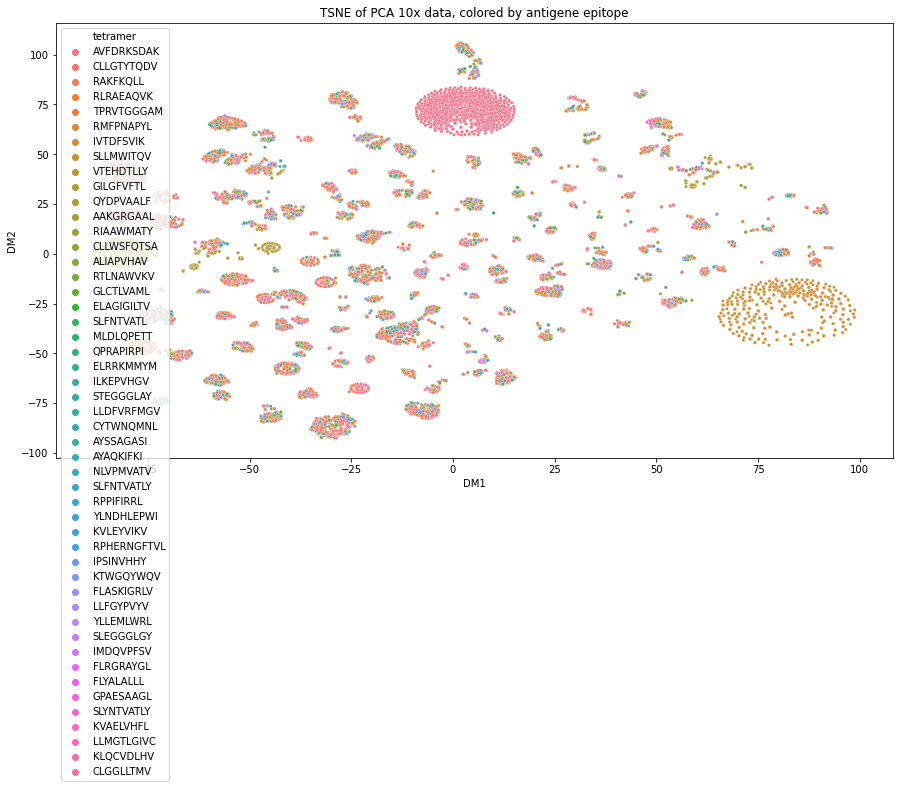

In [29]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)
ax.set_title("TSNE of PCA 10x data, colored by antigene epitope")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)
ax.set_title("TSNE of PCA 10x data, colored by antigene epitope")

## Clustering

In [30]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(pca_df)

In [31]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of PCA 10x data, colored by cluster')

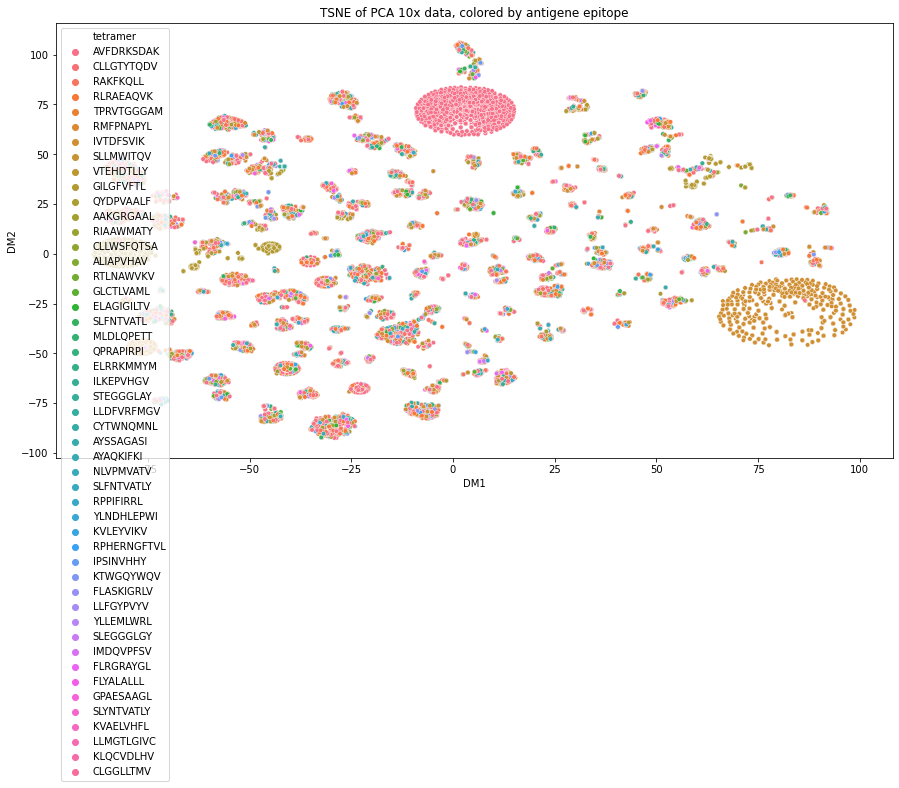

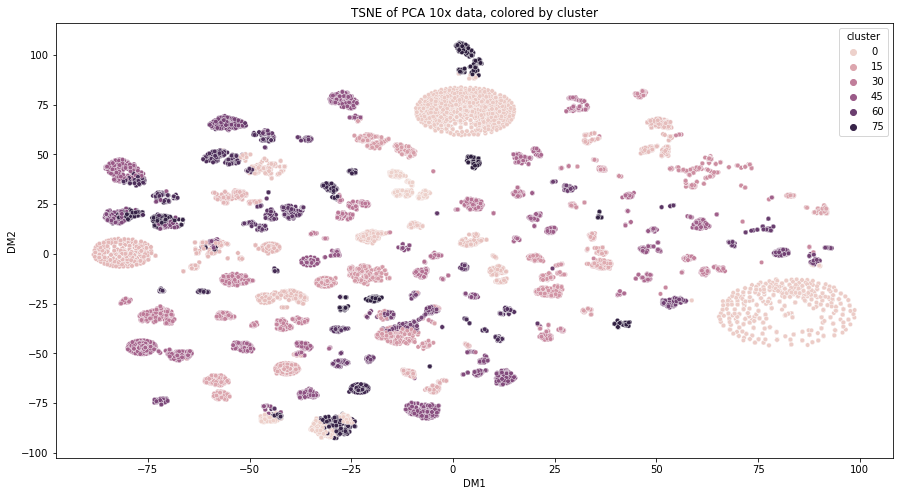

In [32]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='tetramer',s=20)
ax.set_title("TSNE of PCA 10x data, colored by antigene epitope")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)
ax.set_title("TSNE of PCA 10x data, colored by cluster")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of PCA 10x data, colored by count of barcides in each cdr3')

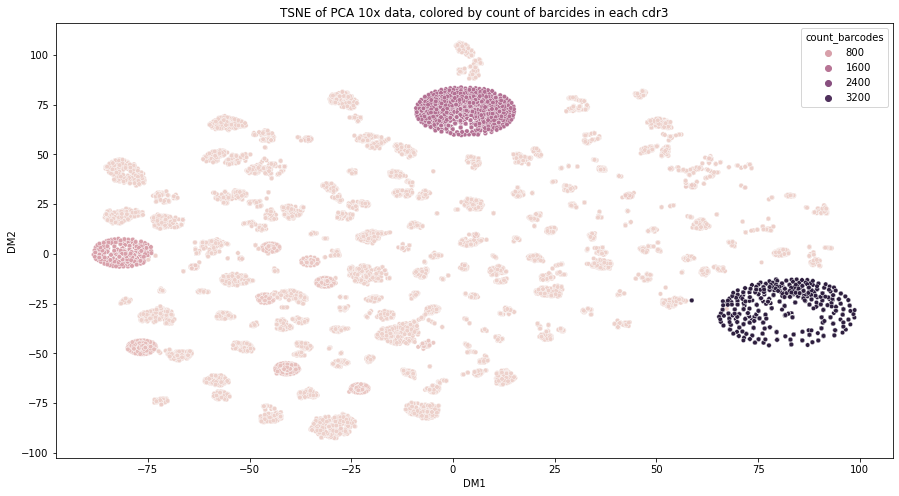

In [33]:
df_kmeans['count_barcodes'] = df_kmeans.groupby('cdr3')['barcode'].transform("size")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='count_barcodes',s=20)
ax.set_title("TSNE of PCA 10x data, colored by count of barcides in each cdr3")

In [34]:
binom_df_cluster = data_processing.binominal_test(df_kmeans,'cluster','tetramer')
binom_df_cluster.head(20)

,tetramer,cluster,total_cluster,total_group,count_mached,fraction_mached,fraction_mached_exp,p_value
14,IVTDFSVIK,2,3740,6708,3721,0.994920,0.233273,0.000000e+00
8,AVFDRKSDAK,3,1701,7058,1676,0.985303,0.245444,0.000000e+00
18,GILGFVFTL,9,1423,3058,1324,0.930429,0.106343,0.000000e+00
42,GILGFVFTL,24,586,3058,515,0.878840,0.106343,0.000000e+00
115,IVTDFSVIK,41,511,6708,332,0.649706,0.233273,7.105152e-89
266,AVFDRKSDAK,73,179,7058,93,0.519553,0.245444,3.154995e-15
259,LLDFVRFMGV,55,124,346,64,0.516129,0.012032,9.682684e-88
175,AVFDRKSDAK,47,253,7058,113,0.446640,0.245444,2.489937e-12
21,AVFDRKSDAK,51,95,7058,42,0.442105,0.245444,2.220920e-05
379,AVFDRKSDAK,37,126,7058,54,0.428571,0.245444,5.131326e-06


## Classification

In [35]:
tetramers = list(tsne_df_data['tetramer'].drop_duplicates())
y_train, y_test,X_train, X_test,  = train_test_split(tsne_df_data['tetramer'],tsne_df,test_size=0.5)
y_test_curv = label_binarize(y_test, classes=tetramers)

In [36]:
# Perform KNN
n_neighbors = 10
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
y_pred_curv = label_binarize(pred, classes=tetramers)

In [37]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

,roc_auc
GILGFVFTL,0.878916
IVTDFSVIK,0.787940
LLDFVRFMGV,0.687609
AVFDRKSDAK,0.648122
FLYALALLL,0.592488
GLCTLVAML,0.552907
ELAGIGILTV,0.537453
RAKFKQLL,0.523306
RLRAEAQVK,0.514118
FLASKIGRLV,0.504983
